## Verifiable factual claims detection: 
Subtask A: Check-worthiness of tweets: Given a tweet, predict whether it is worth fact-checking. This task is defined with binary labels: Yes and No.. This is a classification task.

### About the Dataset
The dataset contains the basic information on "Fighting the COVID-19 Infodemic and Fake News Detection".

### Abstract of the Notebook
For this subtask, we built, tuned and evaluated 2 ML Algorithms - LinearSVC and Logistic Regression.

Class inbalancing is handled using two methods: cost-sensitive learning and up-sampling.

In [ ]:
import re
import numpy as np
import pandas as pd

# nltk
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score
from imblearn.over_sampling import SMOTE

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

In [ ]:
df_train = pd.read_table("CT22_english_1A_checkworthy_train.tsv")
df_test=pd.read_table("CT22_english_1A_checkworthy_dev_test.tsv")

### Preprocessing

In [ ]:
lemmatizer = WordNetLemmatizer()
# Transform words to their root form (called lemma)
def lemmatize_tweet(tweet):
    words = tweet.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)
def pre_process(tweet):
    
    # Remove Emojis
    emojiPattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF"
                           "\U00002500-\U00002BEF\U00002702-\U000027B0\U00002702-\U000027B0\U000024C2-\U0001F251"
                           "\U0001f926-\U0001f937\U0001F1F2-\U0001F1F4\U0001F1E6-\U0001F1FF\u2640-\u2642\u2600-\u2B55"
                           "\u200d\u23cf\u23e9\u231a\u3030]+", flags=re.UNICODE)
    tweet = re.sub(emojiPattern, '', tweet)
    
    # Remove URLs
    urlPattern = r"((http[s]?://)[^\s]*|(www\.)[^\s]*)"
    tweet = re.sub(urlPattern, '', tweet)
    
    # Remove User Mentions
    userPattern = r"@[^\s]+"
    tweet = re.sub(userPattern,'',tweet)
    
    # Lower case
    tweet = tweet.lower()
    
    # Remove sequence pattern
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    
    
    # Lemmatize tweets
    tweet = lemmatize_tweet(tweet)
        
    return tweet

In [ ]:
df_train.tweet_text[5]

'Joel Embiid will donate his $100K ASW earnings to three homeless shelters in Philly to help provide: -Meals -Clothing items -Treatment and care for those who get COVID-19 vaccines -Funds for a summer camp -Shelter for 300+ teens -Support for formerly homeless families 🙏 https://t.co/MlYyAC3E8j'

In [ ]:
x_train = df_train['tweet_text'].apply(pre_process)
y_train = df_train['class_label']

x_test = df_test['tweet_text'].apply(pre_process)
y_test = df_test['class_label']

In [ ]:
x_train[5]

'joel embiid will donate his $100k asw earnings to three homeless shelter in philly to help provide: -meals -clothing item -treatment and care for those who get covid-19 vaccine -funds for a summer camp -shelter for 300+ teen -support for formerly homeless family'

In [ ]:
y_train.value_counts()

0    1675
1     447
Name: class_label, dtype: int64

The data is highly inbalanced.

In [ ]:
# Create Vocablury 
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
print(f'Vectoriser fitted.')
print("Vocabulary: ", len(vectorizer.vocabulary_), " words")

Vectoriser fitted.
Vocabulary:  8164  words


In [ ]:
# Transform training and testing data using the vectorizer
x_train_vector = vectorizer.fit_transform(x_train) 
x_test_vector = vectorizer.transform(x_test)

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(x_test_vector)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Class weight balancing method (cost-sensitive learning)

#### Without any class balancing 

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       445
           1       0.61      0.39      0.47       129

    accuracy                           0.81       574
   macro avg       0.72      0.66      0.68       574
weighted avg       0.79      0.81      0.79       574

[[413  32]
 [ 79  50]]


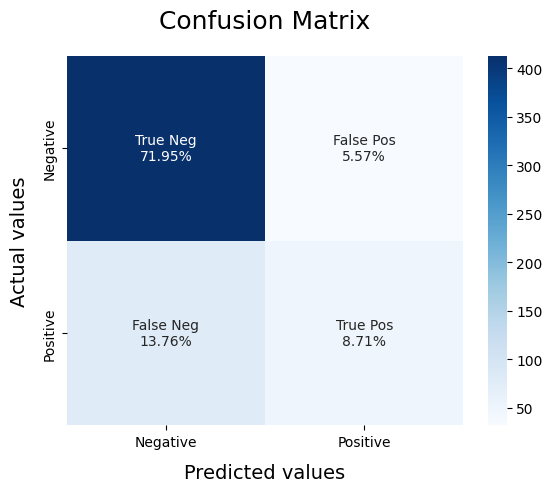

In [ ]:
classifier = LogisticRegression()
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       445
           1       0.57      0.48      0.52       129

    accuracy                           0.80       574
   macro avg       0.71      0.69      0.70       574
weighted avg       0.79      0.80      0.80       574

[[398  47]
 [ 67  62]]


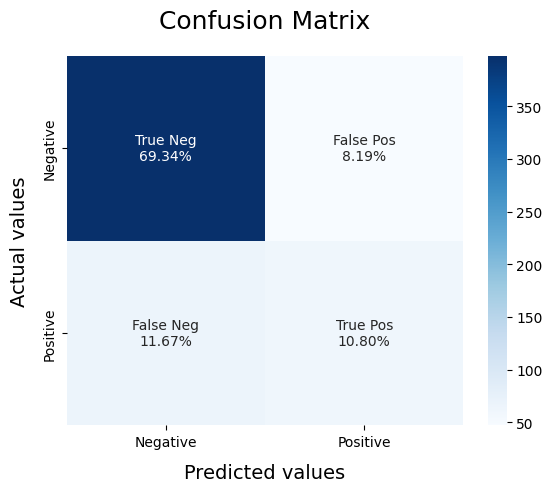

In [ ]:
classifier = LinearSVC( max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

#### With sklearn inbuild balancing method

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       445
           1       0.55      0.56      0.55       129

    accuracy                           0.80       574
   macro avg       0.71      0.71      0.71       574
weighted avg       0.80      0.80      0.80       574

[[386  59]
 [ 57  72]]


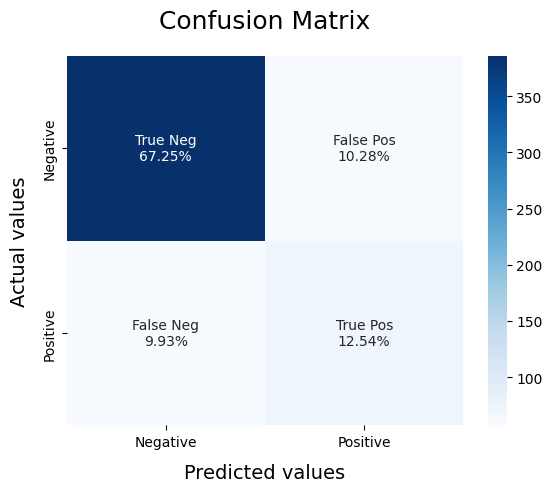

In [ ]:
classifier = LogisticRegression(class_weight='balanced', max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       445
           1       0.57      0.49      0.53       129

    accuracy                           0.80       574
   macro avg       0.71      0.69      0.70       574
weighted avg       0.79      0.80      0.80       574

[[397  48]
 [ 66  63]]


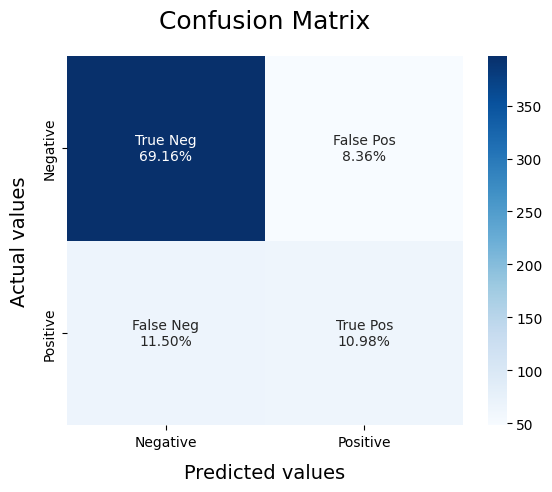

In [ ]:
classifier = LinearSVC( class_weight='balanced', max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

#### With manual class balancing


In [ ]:
def classBal(model,X,Y):
    if model == 'lr':
        model = LogisticRegression()
    elif model == 'svc':
        model=LinearSVC()
        


    #Setting the range for class weights
    weights = np.linspace(0.0,0.99,200)


    #Creating a dictionary grid for grid search
    param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

    #Fitting grid search to the train data with 5 folds
    gridsearch = GridSearchCV(estimator= model, 
                            param_grid= param_grid,
                            cv=StratifiedKFold(), 
                            n_jobs=-1, 
                            scoring='f1', 
                            verbose=2).fit(X,Y)
    weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
    weigh_data.score.max()
    print(weigh_data.score.max())
    for1=weigh_data.weight.where(weigh_data.score >= weigh_data.score.max() ).max()
    # print(for1)
    # print(1-for1)
    return {0: 1-for1, 1:for1}

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.49933166795957007
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       445
           1       0.44      0.74      0.55       129

    accuracy                           0.73       574
   macro avg       0.67      0.73      0.68       574
weighted avg       0.80      0.73      0.75       574

[[323 122]
 [ 34  95]]


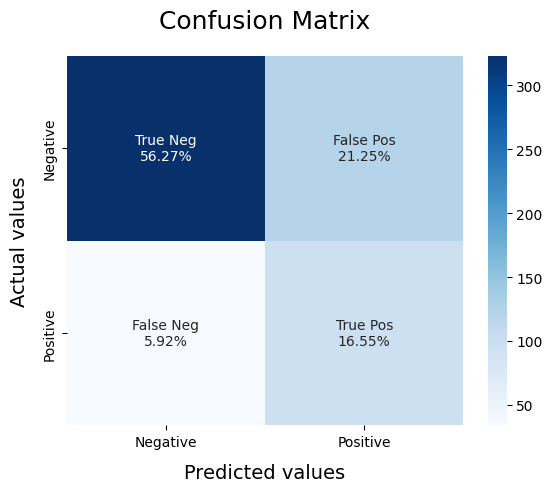

In [ ]:
class_weight=classBal('lr',x_train_vector,y_train)
classifier = LogisticRegression(class_weight=class_weight)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       445
           1       0.56      0.66      0.60       129

    accuracy                           0.80       574
   macro avg       0.73      0.75      0.74       574
weighted avg       0.82      0.80      0.81       574

[[377  68]
 [ 44  85]]


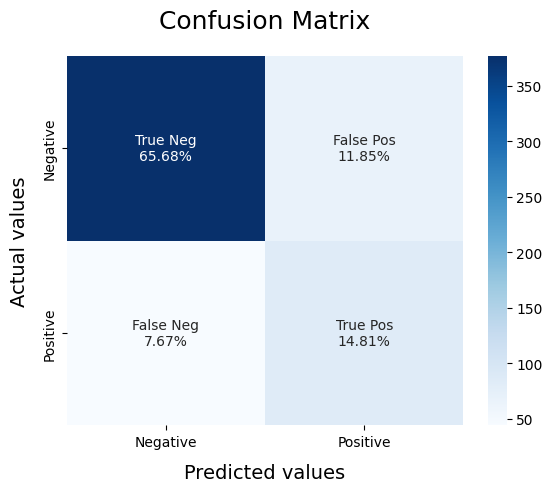

In [ ]:
classifier = LogisticRegression(C=10,class_weight=class_weight,max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.48320097558428216
{0: 0.009949748743718567, 1: 0.9900502512562814}
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       445
           1       0.42      0.78      0.54       129

    accuracy                           0.70       574
   macro avg       0.67      0.73      0.66       574
weighted avg       0.80      0.70      0.73       574

[[303 142]
 [ 28 101]]


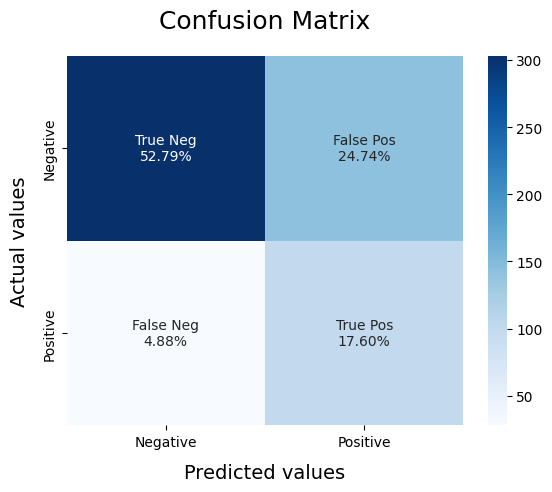

In [ ]:
class_weight=classBal('svc',x_train_vector,y_train)
print(class_weight)
classifier = LinearSVC( class_weight=class_weight, max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.92      0.67      0.77       445
           1       0.41      0.81      0.55       129

    accuracy                           0.70       574
   macro avg       0.67      0.74      0.66       574
weighted avg       0.81      0.70      0.72       574

[[297 148]
 [ 25 104]]


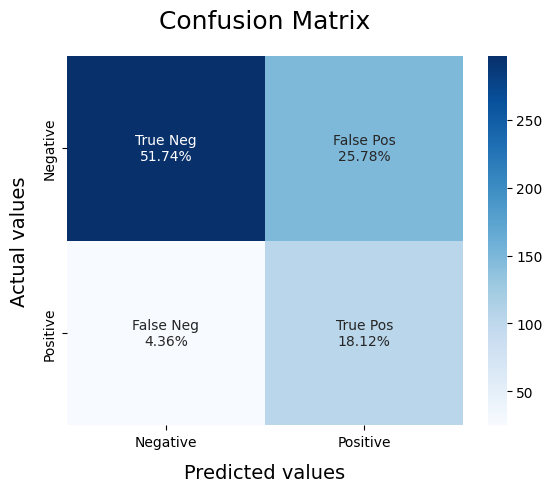

In [ ]:
classifier = LinearSVC( C=0.9,class_weight=class_weight, max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

### Up-sampling lower class with SMOTE

In [ ]:
# Resample using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train_vector, y_train)

In [ ]:
y_train_resampled.value_counts()

0    1675
1    1675
Name: class_label, dtype: int64

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       445
           1       0.48      0.50      0.49       129

    accuracy                           0.77       574
   macro avg       0.67      0.67      0.67       574
weighted avg       0.77      0.77      0.77       574

[[376  69]
 [ 65  64]]


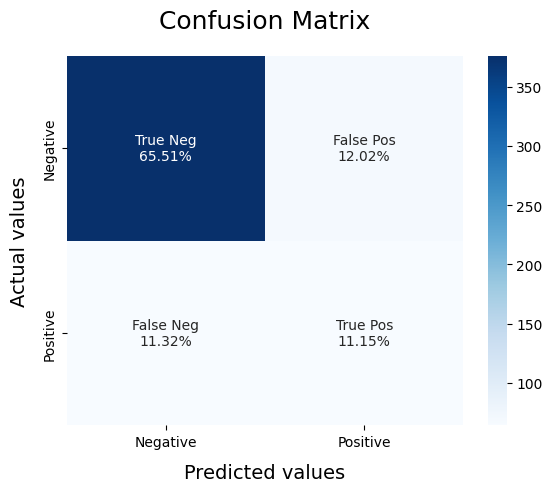

In [ ]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_resampled, y_train_resampled)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       445
           1       0.47      0.52      0.49       129

    accuracy                           0.76       574
   macro avg       0.66      0.67      0.67       574
weighted avg       0.77      0.76      0.76       574

[[369  76]
 [ 62  67]]


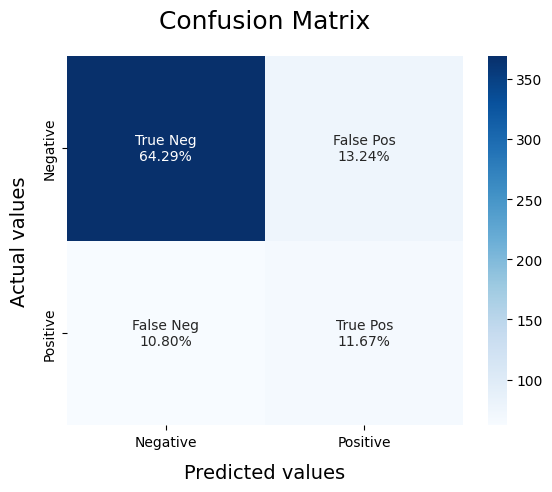

In [ ]:
classifier = LinearSVC(C=0.9,max_iter=1000)
classifier.fit(X_train_resampled, y_train_resampled)
model_Evaluate(classifier)

### Up-sampling and class balancing together

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.7573058731314211
{0: 0.6119095477386934, 1: 0.38809045226130656}


C:\Users\newac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.85      0.85      0.85       445
           1       0.48      0.48      0.48       129

    accuracy                           0.76       574
   macro avg       0.66      0.66      0.66       574
weighted avg       0.77      0.76      0.77       574

[[377  68]
 [ 67  62]]


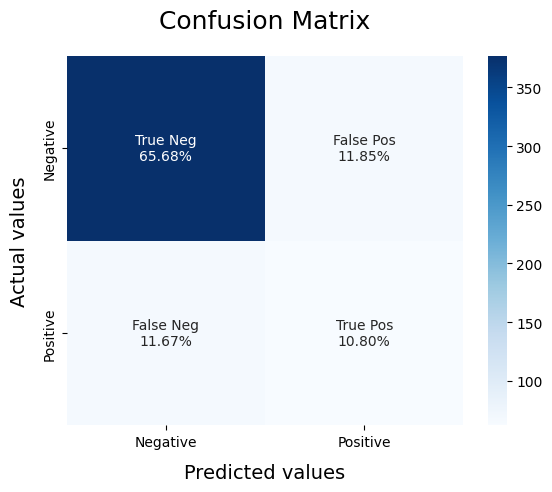

In [ ]:
class_weight=classBal('lr',X_train_resampled, y_train_resampled)
print(class_weight)
classifier = LogisticRegression(class_weight=class_weight)
classifier.fit(X_train_resampled, y_train_resampled)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       445
           1       0.50      0.44      0.47       129

    accuracy                           0.78       574
   macro avg       0.67      0.66      0.66       574
weighted avg       0.77      0.78      0.77       574

[[388  57]
 [ 72  57]]


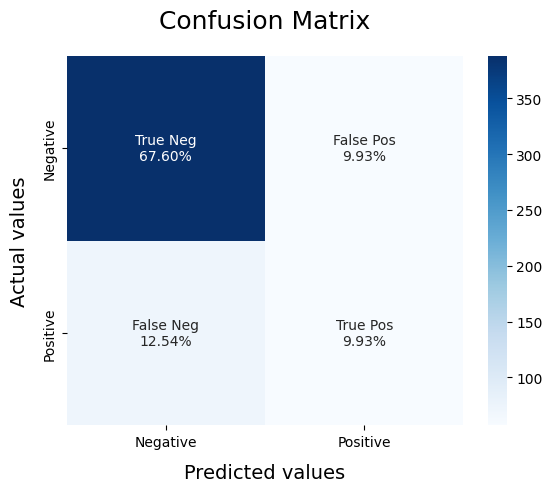

In [ ]:
classifier = LogisticRegression(class_weight=class_weight)
classifier.fit(X_train_resampled, y_train_resampled)
model_Evaluate(classifier)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.7687226051443335
{0: 0.6069346733668342, 1: 0.39306532663316585}
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       445
           1       0.50      0.44      0.47       129

    accuracy                           0.78       574
   macro avg       0.67      0.66      0.66       574
weighted avg       0.77      0.78      0.77       574

[[389  56]
 [ 72  57]]


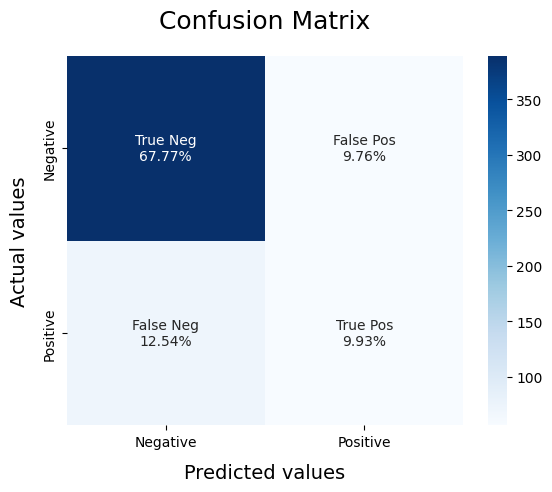

In [ ]:
class_weight=classBal('svc',X_train_resampled, y_train_resampled)
print(class_weight)
classifier = LogisticRegression(C=0.9,class_weight=class_weight)
classifier.fit(X_train_resampled, y_train_resampled)
model_Evaluate(classifier)

### Comparison of all methods


In [ ]:
df_compare = pd.read_csv('eval.csv')

In [ ]:
df_compare

,Model,Weight handling method,Up-sampling,F1 score (0|1),Accurcy
0,LogisticRegression,none,none,0.88|0.47,81
1,LinearSVC,none,none,0.87|0.52,80
2,LogisticRegression,inbuild,none,0.87|0.55,80
3,LinearSVC,inbuild,none,0.87|0.53,80
4,LogisticRegression,manual,none,0.87|0.60,80
5,LinearSVC,manual,none,0.77|0.55,70
6,LogisticRegression,none,SMOTE,0.85|0.49,77
7,LinearSVC,none,SMOTE,0.84|0.49,76
8,LogisticRegression,manual,SMOTE,0.85|0.48,76
9,LinearSVC,manual,SMOTE,0.86|0.47,78


### Conclusion

We can see from the comparison table that both models compare to each other with minute difference. However Logistic regression does well when class balancing is done manually. 

In conclusion, both models can be used to fact check tweets. Performance of both models improve when using class balanced training and shows little to no improvement with up-sampling method.